In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import keras
import random
import pandas as pd
import tensorflow

In [3]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    random.seed(seed_value)
set_seed(42)

In [4]:
os.environ['KERAS_BACKEND'] = 'tensorflow' # Added to set the backend as Tensorflow

In [5]:
''' It returns:
Since the Folders with the images have the following structure:
- ROOT
-- Parasitized
-- Uninfected
I need to construct the corrisponding label
'''
images_dir_path = '../cell_images'  
images_dirs_paths = [name for name in os.listdir(images_dir_path) if name != '.DS_Store']
image_paths = []
image_classes = []
class_id = 0

def imglist(path_dir):    
    return [os.path.join(path_dir, image) for image in os.listdir(path_dir)]

''' It returns:
- image_paths: list of paths to all the images
- image_classes: list of labels
'''
for images_dir in images_dirs_paths:
    sub_dir = os.path.join(images_dir_path, images_dir)
    class_path = imglist(sub_dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [6]:
images_dirs_paths

['Parasitized', 'Uninfected']

In [7]:
len(image_paths)

27560

In [8]:
len(image_classes)

27560

In [9]:
SIZE = 96

In [10]:
image_data = []
labels = []

index = 0
for image_path in image_paths:
    if '.png' in image_path:
        image = cv2.imread(image_path)
        if image is not None:
            # Convert to RGB using PIL
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            # Resize the image
            image = image.resize((SIZE, SIZE))
            image_data.append(np.array(image))
            labels.append(image_classes[index])  # Update this according to your label retrieval logic
        else:
            print(f"Image {image_path} could not be loaded")
    else:
        print(f"Image {image_path} is not a PNG file")
    index += 1

Image ../cell_images/Parasitized/Thumbs.db is not a PNG file


Image ../cell_images/Uninfected/Thumbs.db is not a PNG file


In [ ]:
def  plot_random(path_images, num = 5):
    indices = np.random.choice(len(path_images),num*2,replace=False)

    plt.figure(figsize=(16,9))
    for i in range(num * 2): ## matplotlib starts from 1 differently from when using python
        plt.subplot(2,num, i+1) # 2 row with 5 columns, i want to allocate the neext image in the position i+1
        plt.title("Cell")
        path_img = path_images[indices[i]]
        img = cv2.imread(path_img)  # Reads in BGR format (the output is in BRG) 
        im_resized = cv2.resize(img, (128, 128))
        plt.imshow(im_resized )
    
plot_random(image_paths, num = 5)

In [18]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(np.array(image_data), to_categorical(np.array(labels)), test_size = 0.20, random_state = 0)

In [29]:
INPUT_SHAPE = (SIZE, SIZE, 3)  
inp = keras.layers.Input(shape=INPUT_SHAPE)

conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.3)(norm1)
conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.3)(norm2)

flat = keras.layers.Flatten()(drop2)  #Flatten the matrix to get it ready for dense.

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.3)(norm3)
hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.3)(norm4)

out = keras.layers.Dense(2, activation='sigmoid')(drop4)   #units=1 gives error

model = keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='categorical_crossentropy',   #Check between binary_crossentropy and categorical_crossentropy
                metrics=['accuracy'])
print(model.summary())

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,583,010 (36.56 MB)

 Trainable params: 9,581,346 (36.55 MB)

 Non-trainable params: 1,664 (6.50 KB)

None


In [30]:
weight_decay = 1e-4 # larger means more regularization!
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001,weight_decay=weight_decay)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy','precision', 'recall'])

#Fit the model
history = model.fit(np.array(X_train), 
                         y_train, 
                         batch_size = 64, 
                         verbose = 1, 
                         epochs = 5,      
                         validation_split = 0.1,
                         shuffle = False
                      #   callbacks=callbacks
                     )

Epoch 1/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 132s 415ms/step - accuracy: 0.6376 - loss: 0.8037 - precision: 0.5867 - recall: 0.6173 - val_accuracy: 0.5642 - val_loss: 4.1266 - val_precision: 0.5634 - val_recall: 0.5338
Epoch 2/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 127s 408ms/step - accuracy: 0.8790 - loss: 0.3037 - precision: 0.8297 - recall: 0.8367 - val_accuracy: 0.8449 - val_loss: 0.5356 - val_precision: 0.8629 - val_recall: 0.8077
Epoch 3/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 130s 417ms/step - accuracy: 0.9180 - loss: 0.2215 - precision: 0.8904 - recall: 0.8806 - val_accuracy: 0.9229 - val_loss: 0.2066 - val_precision: 0.9474 - val_recall: 0.8830
Epoch 4/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 128s 411ms/step - accuracy: 0.9353 - loss: 0.1844 - precision: 0.9039 - recall: 0.9024 - val_accuracy: 0.9156 - val_loss: 0.2608 - val_precision: 0.9258 - val_recall: 0.9002
Epoch 5/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 128s 411ms/step - accuracy: 0.9363 - loss: 0.1747 - precision: 0.9095 - recall: 0.9051 - val_accuracy: 0.9261

# Evaluation!

In [31]:
print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))

173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9287 - loss: 0.1932 - precision: 0.9022 - recall: 0.9314
Test_Accuracy: 93.20%


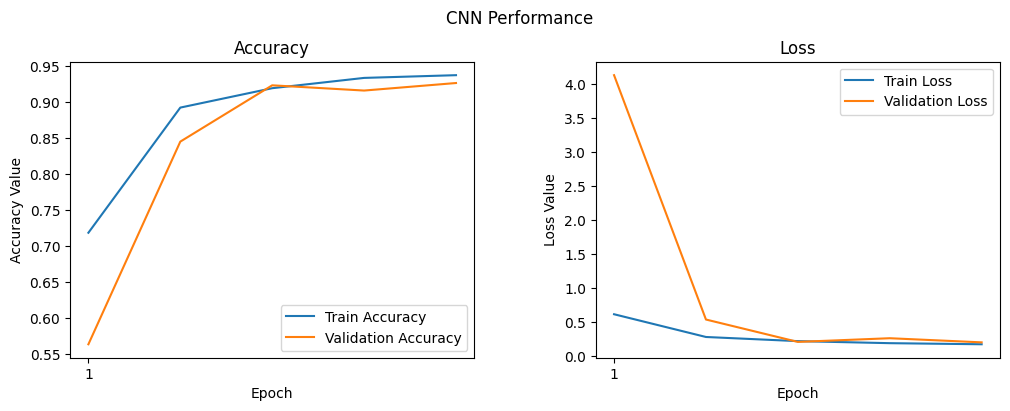

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")